<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_2_OLCI_file_structure.ipynb" target="_blank"><< OLCI file structure</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_4_OLCI_bands_imagery.ipynb" target="_blank">OLCI bands and imagery >></a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Ben Loveday (EUMETSAT/Innoflair UG), Hayley Evers-King (EUMETSAT)

<div class="alert alert-block alert-success">
<h3>Learn OLCI: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook:
  - **<a href="./1_1a_OLCI_data_access_Data_Store.ipynb" target="_blank">1_1a_OLCI_data_access_Data_Store.ipynb</a>** (if using the Data Store)
    <br><br>**OR**<br><br>
  - **<a href="./1_1b_OLCI_data_access_HDA.ipynb" target="_blank">1_1b_OLCI_data_access_HDA.ipynb</a>** (if using WEkEO)
    
</div>
<hr>

# 1.3 Determining OLCI product coverage

### Data used


| Product Description | Data Store collection ID| Product Navigator | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-3 OLCI level-2 full resolution | EO:EUM:DAT:0407 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:OL_2_WFR___NTC?query=OLCI&filter=satellite__Sentinel-3&filter=instrument__OLCI&filter=processingLevel__Level%202%20Data&s=advanced" target="_blank">link</a> | EO:EUM:DAT:SENTINEL-3:OL_2_WFR___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3AOL_1_EFR___" target="_blank">link</a> |
| Sentinel-3 OLCI level-2 reduced resolution | EO:EUM:DAT:0408 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:OL_2_WRR___NTC?query=OLCI&filter=satellite__Sentinel-3&filter=instrument__OLCI&filter=processingLevel__Level%202%20Data&s=advanced" target="_blank">link</a> | EO:EUM:DAT:SENTINEL-3:OL_2_WRR___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3AOL_2_WRR___" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will know;
* About the "Product Dissemination Units" that OLCI data is distributed in.
* What the OLCI PDU's look like in terms of ground coverage.
* What this means for 'revisit time' or how often you can get data for a specific area.
* How to extract the polygon which represents data coverage from an OLCI data product manifest file.
* How to visualise this information on a map.

### Outline

    
Whilst the Sentinel-3 satellites continuously orbit the planet, data received must be split in to manageable portions for processing and distribution. Data from the Ocean and Land Colour Instrument aboard the Sentinel-3 satellites, is distributed in specific "product dissemination units" (PDUs). You can find out detailed information about the different types of PDUs and which ones are used for which Sentinel-3 products in the <a href="https://eumetsatspace.atlassian.net/wiki/spaces/DPF/pages/1615659023/Product+dissemination+units+PDUs" target="_blank">EUMETSAT user support knowledge base</a>

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Investigating OLCI coverage](#section1)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library imports
import cartopy                       # a library that support mapping
import glob                          # a library that aids in searching for files
import matplotlib.pyplot as plt      # a library that support plotting
import numpy as np                   # a library that provides support for array-based mathematics
import os                            # a library that allows us access to basic operating system commands like making directories
from shapely.geometry import Polygon # a library that helps us work with shape objects
import warnings                      # a library that helps us manage warnings
import xml.etree.ElementTree as ET   # a library that helps us parse XML files
warnings.filterwarnings('ignore')

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Investigating OLCI coverage
[Back to top](#TOC_TOP)

</div>

First let's create a path that points to the location of the data files we're interesed in. We'll look at two different types of OLCI data product, which will show us examples of the two different types of PDUs for OLCI data. 

In [2]:
# selecting SAFE directories
SAFE_directories = [
    os.path.join(os.getcwd(), 'products',
    'S3A_OL_2_WFR____20210717T101015_20210717T101315_20210718T221347_0179_074_122_1980_MAR_O_NT_003.SEN3'),
    os.path.join(os.getcwd(), 'products',
    'S3A_OL_2_WRR____20210717T095732_20210717T104152_20210718T152419_2660_074_122______MAR_O_NT_003.SEN3')
    ]

We don't always need to open the actual data files contained within the Sentinel-SAFE file in order to find out information about the products. Some information is stored in the manifest file - like the information about what area is covered by the particular data files. In the cell below, we'll find the manifest files in the directories of the products we selected above.

In [3]:
# selecting SAFE manifest
SAFE_manifests = []
for SAFE_directory in SAFE_directories:
    SAFE_manifests.append(glob.glob(os.path.join(SAFE_directory, 'xfd*.xml'))[0])

Next, we'll look inside the manifest files and extract the polygons which represent the coverage of the data within the files.

In [4]:
polygons = []
tags = []
for SAFE_manifest in SAFE_manifests:
    tags.append(SAFE_manifest.split('/')[-2])
    tree = ET.parse(SAFE_manifest)
    root = tree.getroot()
    polygon =  root.findall('.//gml:posList', {'gml':"http://www.opengis.net/gml"})
    polygons.append((polygon[0].text))

Finally, we'll plot the polygons on a world map...

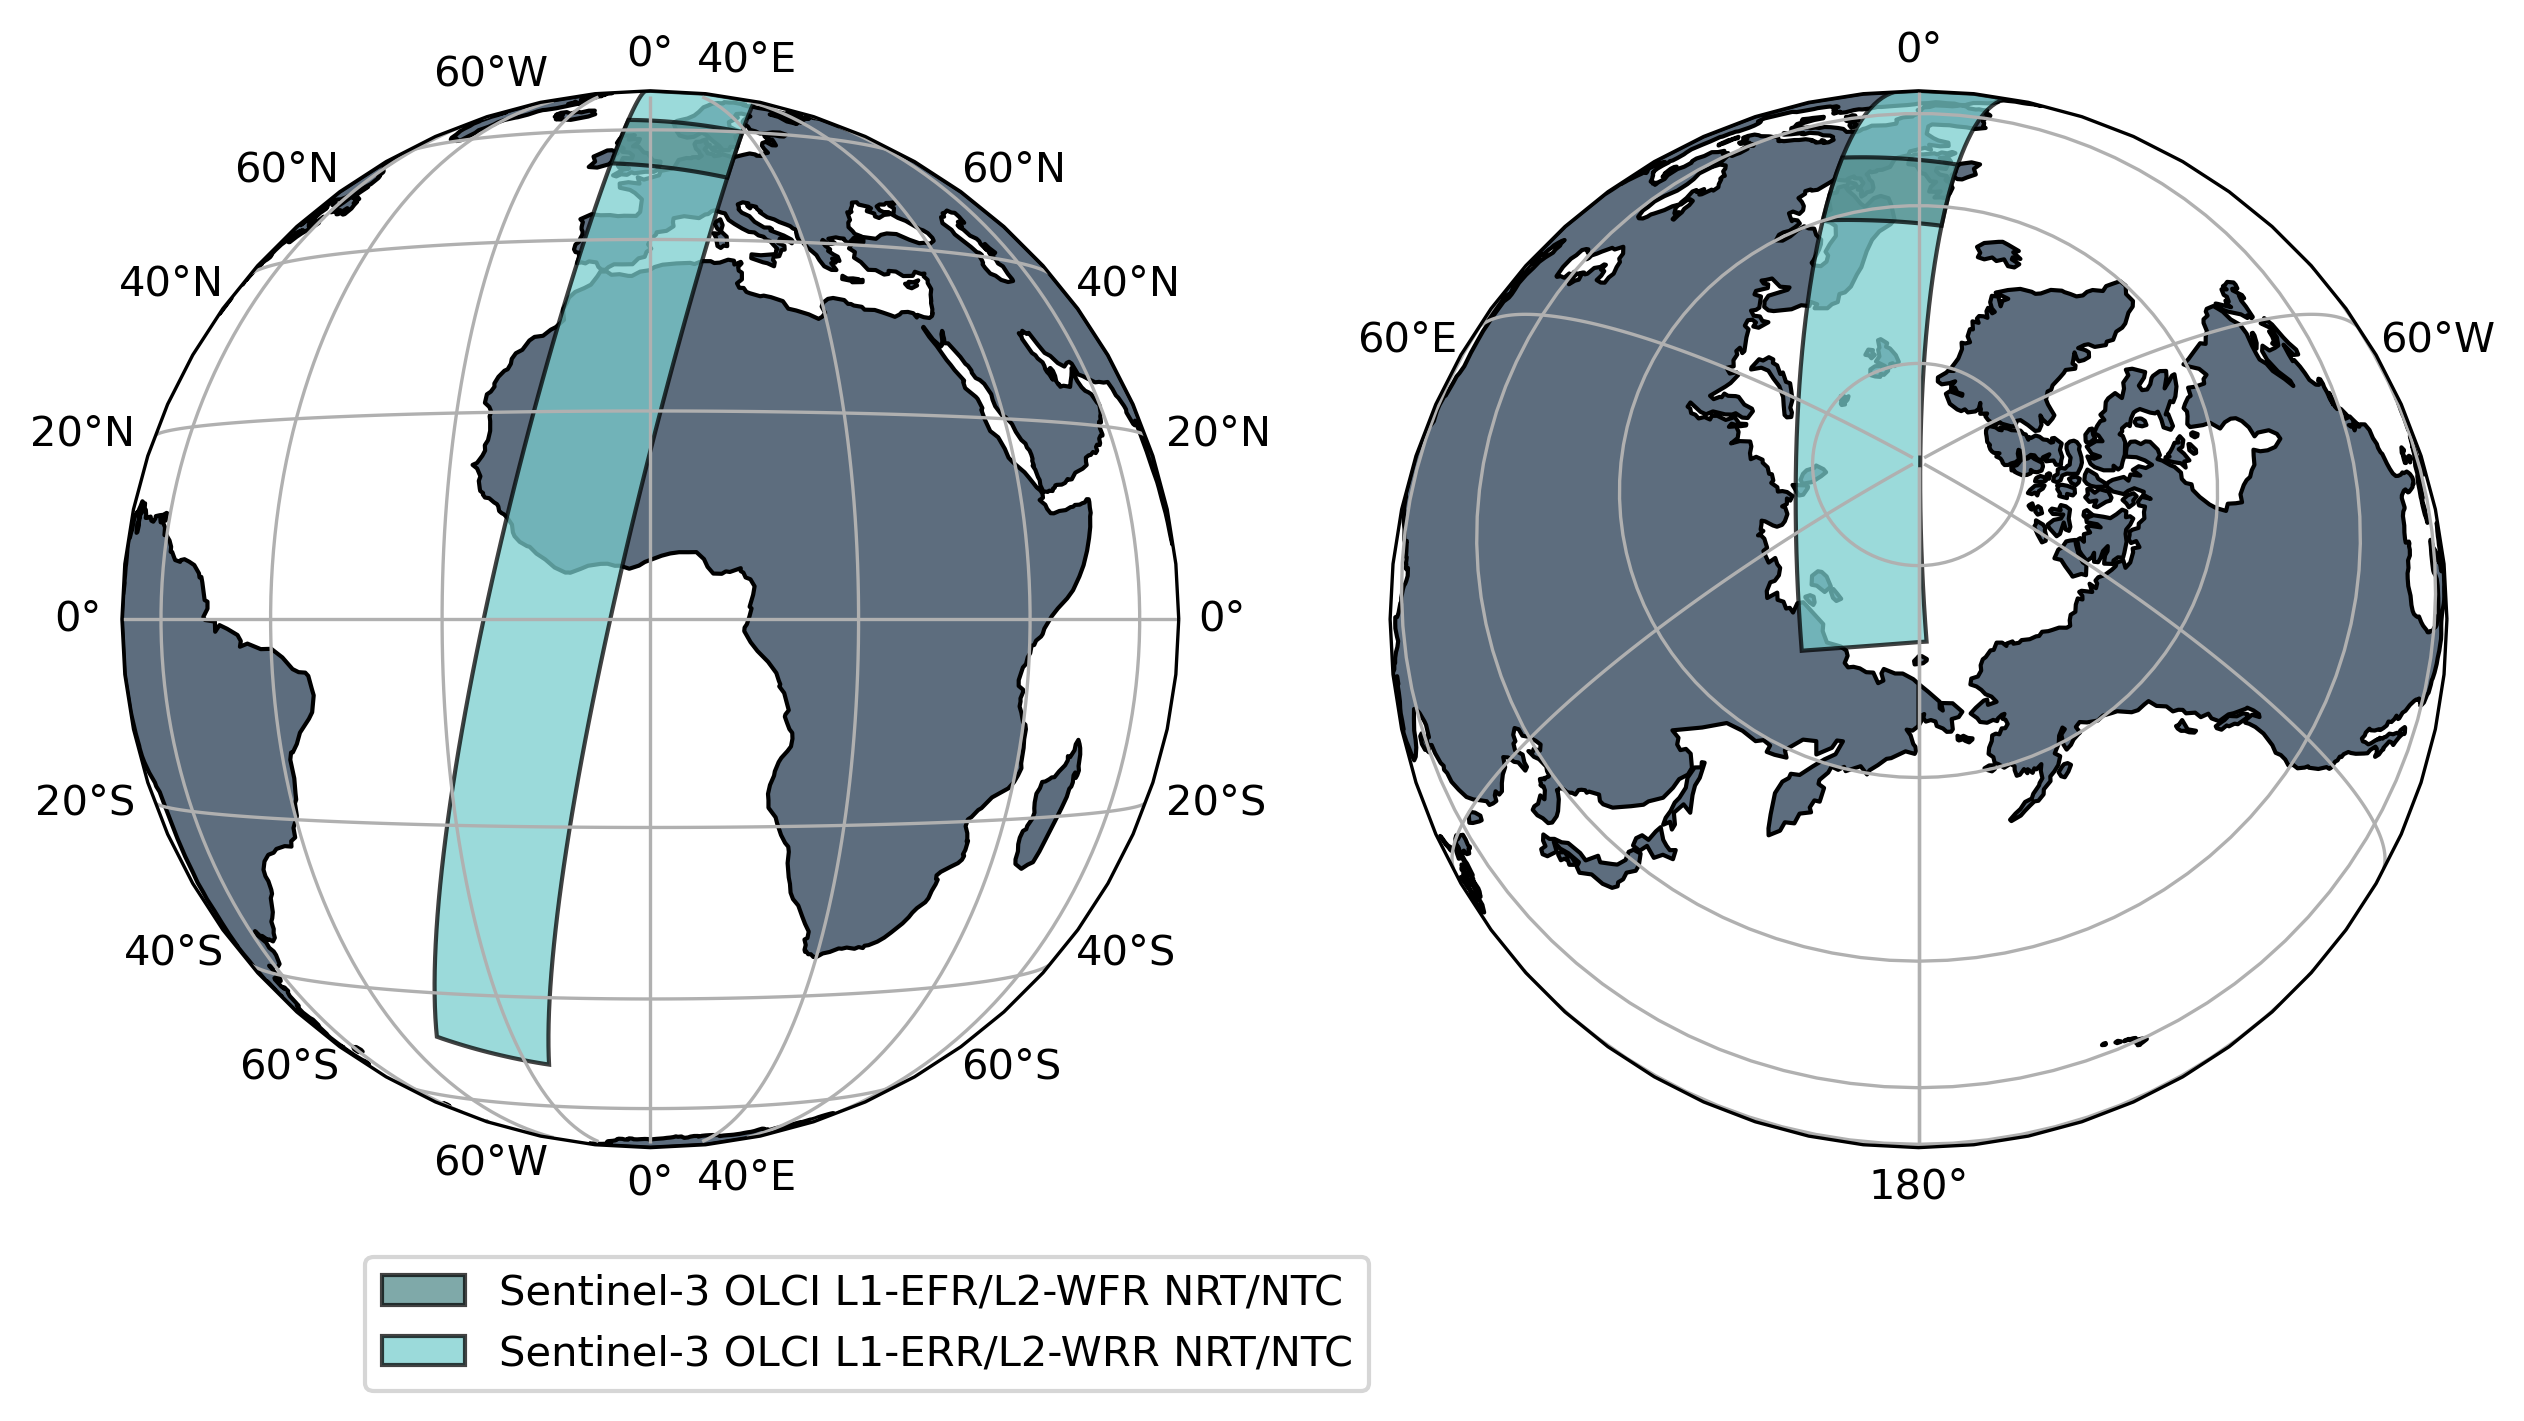

In [5]:
fig1 = plt.figure(figsize=(10, 10), dpi=300)

for loc, clon, clat in zip([1, 2], [0.0, 180.0], [0.0, 75]):
    m = plt.subplot(1, 2, loc, projection=cartopy.crs.NearsidePerspective(central_longitude=clon, 
                                                                          central_latitude=clat))
    m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
    m.set_global()

    gl = m.gridlines(draw_labels = True)

    colours = ['#528B8B', '#79CDCD']
    zorders = [2, 1]
    labels = ['Sentinel-3 OLCI L1-EFR/L2-WFR NRT/NTC', 'Sentinel-3 OLCI L1-ERR/L2-WRR NRT/NTC']

    plots = []
    reverse = False
    for polygon, tag, colour, zorder, SAFE_manifest in zip(polygons, tags, colours, zorders, SAFE_manifests):
        coords = np.asarray(polygon.split(' ')).astype('float')
        polygon_geom = Polygon(zip((coords[1::2]), coords[0::2]))
        px = polygon_geom.exterior
        if reverse == True:
            px.coords = list(px.coords)[::-1]
        x, y = px.xy
        p, = plt.fill(x, y, alpha=0.74, fc=colour, ec='k', transform=cartopy.crs.Geodetic(), zorder=zorder)
        plots.append(p)

plt.legend(plots, labels, loc='lower right', bbox_to_anchor=(0.0, -0.25))
plt.savefig('1_3_OLCI_coverage.png', bbox_inches='tight')

In the plot above we can see that the OLCI Full Resolution (EFR and WFR) and Reduced Resolution (ERR and WRR) products have different PDUs. The FR products are delivered in frames, whilst the the RR products are delivered as stripes that represent half an orbits worth of data. The PDUs for OLCI data products are the same for each resolution at both levels (1B and 2), and timeliness (Near Real Time (NRT) and Non Time Critical (NTC)).


### What to try next?

Why not try downloading a different OLCI file and seeing how the coverage varies? You could also download multiple files from the same day, layer them together on the same plot, and see how much coverage one, or both Sentinel-3 satellites provide. 

You could compare a day in summer, to one in winter...what do you notice? Does the coverage change?

For more information on OLCI data coverage, see the 
<a href="https://eumetsatspace.atlassian.net/wiki/spaces/SEN3/pages/1609367573/OLCI+coverage" target="_blank">Sentinel-3 knowledge base pages</a>.

<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_2_OLCI_file_structure.ipynb" target="_blank"><< OLCI file structure</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_4_OLCI_bands_imagery.ipynb" target="_blank">OLCI bands and imagery >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean" target="_blank">View on GitLab</a> | <a href="https://training.eumetsat.int/" target="_blank">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int target="_blank">Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int target="_blank">Contact our training team to collaborate on and reuse this material</a></span></p>